In [2]:
import torch
import torchvision
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')

  os.chdir('/content/drive/MyDrive/GitHub/kornia')
except Exception:   # Not run on Google Colab
  import getpass
  if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
  else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))

print(os.getcwd())
import sys
sys.path.append(os.getcwd())
cwd_path = os.getcwd()

from kornia.nerf.camera_utils import parse_colmap_output, cameras_for_ids
from kornia.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/kornia


## Load scene images and plot one of them

torch.Size([3, 756, 1008])
10


torch.Size([756, 1008, 3])

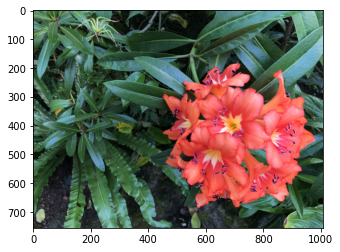

In [9]:
img_paths = sorted(glob.glob('kornia/nerf/kornia_nerf_data/flower_4/images/*.png'))
img0 = read_image(img_paths[0])
print(img0.shape)

downscale = 1.  # Scaling facor to downsize images for faster computation
height = int(img0.shape[1] / downscale)
width = int(img0.shape[2] / downscale)
transform = torchvision.transforms.Resize((height, width))
imgs: torch.tensor = []
camera_ids = []
num_cams_to_load = 10
for i, img_path in enumerate(img_paths):
    if num_cams_to_load != -1 and i == num_cams_to_load:
        break
    img = read_image(img_path)
    img = transform(img)  # Uncomment to apply downsizing
    imgs.append(img)
    camera_ids.append(i)

print(len(imgs))
img_plt = torch.permute(imgs[0], (1, 2, 0))
plt.imshow(img_plt)
img_plt.shape

## Parse cameras from estimated pos xml

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

# camera_parser = CameraParser('./test/geometry/nerf/cameras.xml', device=device)
# cameras = camera_parser.create_cameras()

# cameras = create_cameras_at_origin(cameras) # Put all cameras at origin, facing positive z-axis
# cameras = initialize_cameras_at_origin(cameras) # Initialize all cameras at origin, focals equals image size
# cameras = initialize_camera_symmetric_intrinsics(cameras)   # Initialize camera intrinsics to symmetric

# cameras.extrinsics[..., :3, :3] *= -1.

img_names, cameras = parse_colmap_output(cameras_path='kornia/geometry/nerf/kornia_nerf_data/flower_4/cameras.txt', 
                              images_path='kornia/geometry/nerf/kornia_nerf_data/flower_4/images.txt', device=device)

# To use same subset of cameras as input images
cameras = cameras_for_ids(cameras, camera_ids)

# Downscaling cameras
cameras = cameras.scale(1. / downscale)

print(cameras.batch_size)
for i in range(cameras.batch_size):
  print(f'Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

cuda
10
Intrinsics: 
tensor([[845.5654,   0.0000, 504.0000,   0.0000],
        [  0.0000, 845.5654, 378.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.9992, -0.0314,  0.0242,  5.4173],
        [ 0.0305,  0.9989,  0.0356,  2.3494],
        [-0.0253, -0.0349,  0.9991, -1.4050],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[845.5654,   0.0000, 504.0000,   0.0000],
        [  0.0000, 845.5654, 378.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.9992, -0.0312,  0.0267,  4.1979],
        [ 0.0303,  0.9990,  0.0316,  2.3504],
        [-0.0276, -0.0307,  0.9991, -1.3962],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[845.5654,   0.0000, 504.0000,   0.0000],
        [  0.0000, 845.5654, 378.

## Run training on image scene

In [11]:
# nerf_obj = NerfSolver(device=device)
# num_img_rays = 256
# batch_size = 256
# nerf_obj.init_training(cameras=cameras, min_depth=1., max_depth=2., ndc=True, imgs=imgs, num_img_rays=num_img_rays, 
#                        batch_size=batch_size, num_ray_points=128)

In [12]:
nerf_obj = NerfSolver(device=device)
num_img_rays = 1024
batch_size = 4096

nerf_obj.init_training(cameras=cameras, min_depth=1., max_depth=3., ndc=False, imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=batch_size, num_ray_points=256, irregular_ray_sampling=True)

# torch.manual_seed(0)    # For reproducibility of random processes

nerf_obj.run(num_epochs=10000)

Epoch: 0: epoch_psnr = 11.004454612731934; time: 21:58:07
Epoch: 10: epoch_psnr = 12.827892303466797; time: 21:58:20
Epoch: 20: epoch_psnr = 13.259321212768555; time: 21:58:33
Epoch: 30: epoch_psnr = 13.748332977294922; time: 21:58:46
Epoch: 40: epoch_psnr = 14.286249160766602; time: 21:58:59
Epoch: 50: epoch_psnr = 14.61475944519043; time: 21:59:12
Epoch: 60: epoch_psnr = 14.837137222290039; time: 21:59:25
Epoch: 70: epoch_psnr = 15.038948059082031; time: 21:59:38
Epoch: 80: epoch_psnr = 15.102867126464844; time: 21:59:51
Epoch: 90: epoch_psnr = 15.429763793945312; time: 22:00:04
Epoch: 100: epoch_psnr = 15.510101318359375; time: 22:00:17
Epoch: 110: epoch_psnr = 15.706305503845215; time: 22:00:30
Epoch: 120: epoch_psnr = 15.845266342163086; time: 22:00:43
Epoch: 130: epoch_psnr = 16.048011779785156; time: 22:00:56
Epoch: 140: epoch_psnr = 16.2672119140625; time: 22:01:09
Epoch: 150: epoch_psnr = 16.429258346557617; time: 22:01:22
Epoch: 160: epoch_psnr = 16.42031478881836; time: 22:0

In [13]:
# nerf_obj.run(num_epochs=10000)

## Rendering novel views

### Sub-set of input cameras

In [15]:
from kornia.nerf.camera_utils import cameras_for_ids

camera_ids = [0]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [16]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

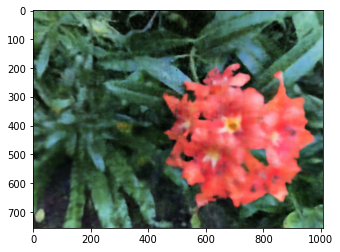

In [17]:
plt.imshow(imgs_rendered[0])

### Spiral pattern

In [18]:
from kornia.nerf.camera_utils import create_spiral_path

cameras_spiral = create_spiral_path(cameras, rad=1., num_views=30, num_circles=2)
imgs_rendered_spiral = nerf_obj.render_views(cameras_spiral)

RuntimeError: ignored

In [ ]:
import numpy as np
import imageio

imgs_rendered_spiral_numpy = [img_rendered_spiral.cpu().numpy() for img_rendered_spiral in imgs_rendered_spiral]

dir = 'kornia/geometry/nerf/kornia_nerf_data/flower_4'
scene_name = 'flower_4'
gif_path = os.path.join(dir, scene_name + '_spiral.gif')
imageio.mimwrite(gif_path, imgs_rendered_spiral_numpy, fps=30)

In [ ]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())